In [2]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro


importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [3]:
dataset = 'ecoVal'
models  = ['ego','saycam', 'supervised']
#models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 768)

In [4]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    #activations[model] = activations[model]/norms # normalization

In [6]:
### check if images were shown in the same order
assert imagelists[models[0]] == imagelists[models[1]]
imagelist = imagelists[models[0]] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

nb_per_cat

50

In [7]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [16]:
compactness, compact_categories = max_rsa.compute_compactness(cat_activations, models, listcat, measure = 'Fisher_discriminant')

ego
supervised


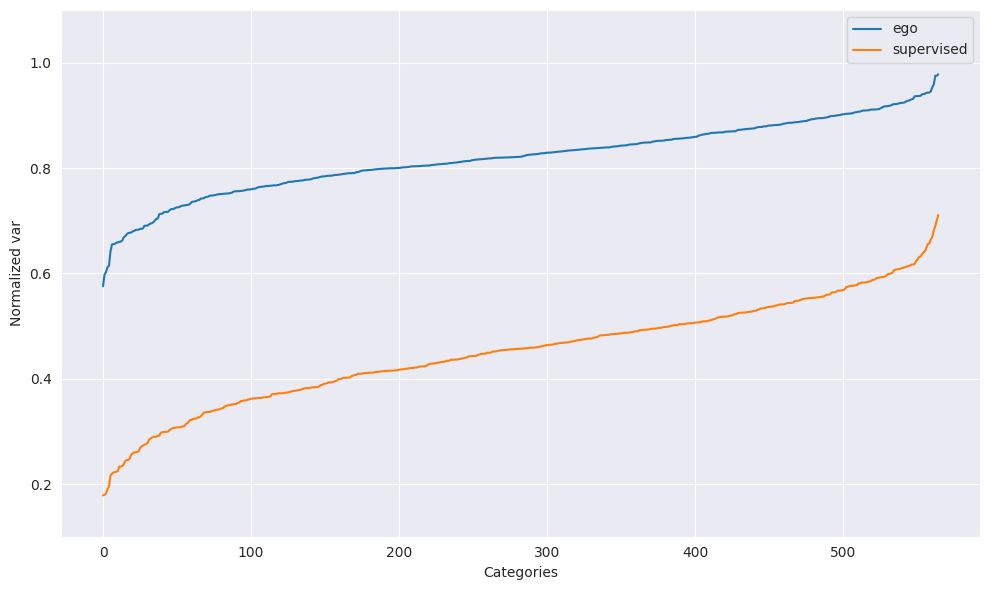

In [17]:
max_rsa.plot_stats_one(compactness,models,  ['Categories', 'Normalized var'])

In [18]:
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(
                compact_categories, compactness, nb_categories, listcat, models = ['ego', 'supervised'],
                nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff'
            )

12
The 12 categories leading to the max differences between ego and supervised are ['0001_man' '2364_robot' '1130_kangaroo' '1782_parsley' '0005_house'
 '0867_bulldozer' '0822_grasshopper' '1530_stadium' '1634_earpiece'
 '0009_car' '0052_fish' '0082_kitchen']
Category numbers are [  0 521 337 459   1 267 253 417 437   2  13  23]
With differences in compactness of  [ 1.2063438  -1.1623743  -1.1540437  -1.139498    1.0709736  -1.0025233
  0.9833537  -0.9802011  -0.9735354   0.9644795   0.9500446   0.93841124]


In [37]:
max_dissimilarity_images = max_rsa.find_max_dissimilarity_images(
                cat_activations, ['ego', 'supervised'], labels[:12], nb_per_cat,
                images_per_subset=4, similarity_metric='contrast', diff = maxdiffs
            )

{'x': np.float32(1068.4453), 'y': np.float32(54712.355), 'norm': np.float32(1427490.5)}


Processing categories:   0%|          | 0/12 [00:00<?, ?it/s]


Processing category: 0
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 0: [ 6 22 35 45]
Similarity: -0.3859

Processing category: 521
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 521: [ 0 14 19 28]
Similarity: -0.6099

Processing category: 337
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 337: [ 1 17 21 48]
Similarity: -0.7388

Processing category: 459
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 459: [ 0 13 37 40]
Similarity: -0.5041

Processing category: 1
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 1: [21 30 44 48]
Similarity: -0.1897

Processing category: 267
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 267: [20 23 25 43]
Similarity: -0.6596

Processing category: 253
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 253: [15 21 23 24]
Similarity: -0.2171

Processing category: 417
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 417: [ 5 14 19 38]
Similarity: -0.6475

Processing category: 437
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 437: [ 0 12 18 22]
Similarity: -0.9233

Processing category: 2
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 2: [ 7 18 38 44]
Similarity: -0.1057

Processing category: 13
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 13: [32 33 44 49]
Similarity: -0.4865

Processing category: 23
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 23: [17 31 37 46]
Similarity: -0.2578


{'x': np.float32(1068.4453), 'y': np.float32(54712.355), 'norm': np.float32(1427490.5)}

Total selected images: 48
Extracting sub-RDMs...
RDM shapes: (48, 48), (48, 48)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.122140


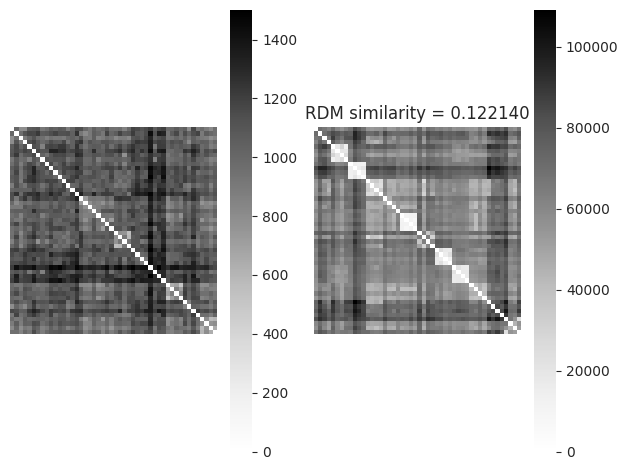

In [38]:
similarity_dict = max_rsa.compute_sub_rdm_similarity(
            max_dissimilarity_images, cat_activations, ['ego', 'supervised'], labels[:12])

In [26]:
categories = labels[:12]
results = max_dissimilarity_images
cat_activations_subset1 = cat_activations[models[0]][labels[:12]]
cat_activations_subset2 = cat_activations[models[1]][labels[:12]]

cat_shape = cat_activations_subset1.shape

RDM1 = rsa.compute_RDMs(cat_activations_subset1.reshape(cat_shape[0] * cat_shape[1], -1),
                        metric='L2squared', display=False)
RDM2 = rsa.compute_RDMs(cat_activations_subset2.reshape(cat_shape[0] * cat_shape[1], -1),
                        metric='L2squared', display=False)
means = {}
n = len(RDM1)
upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
means['x'] = np.mean(RDM1[upper_indices])
means['y'] = np.mean(RDM2[upper_indices])
means['norm'] = np.std(RDM1[upper_indices]) * np.std(RDM2[upper_indices])
print(means)

# Collect selected image indices from all categories
selected_indices = []
selected_indices_2display = []
image_info = []  # Track which category and original index each image comes from

total_selected = 0

for c, category in enumerate(categories):
    if category not in results:
        raise ValueError(f"Category {category} not found in results")

    # Get the 4 selected indices for this category
    cat_selected_indices = results[category]['best_indices']

    # Add to combined list
    selected_indices.extend(cat_selected_indices + 50*c)
    selected_indices_2display.extend(cat_selected_indices + 50 * category)

    # Track image information
    for idx in cat_selected_indices:
        image_info.append((category, idx))

    total_selected += len(cat_selected_indices)
    #print(f"Category {category}: selected indices {cat_selected_indices}")

{'x': np.float32(1068.4453), 'y': np.float32(54712.355), 'norm': np.float32(1427490.5)}


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

Loading 48 images with lowest RDM column similarity...
Successfully loaded 48 out of 48 requested images


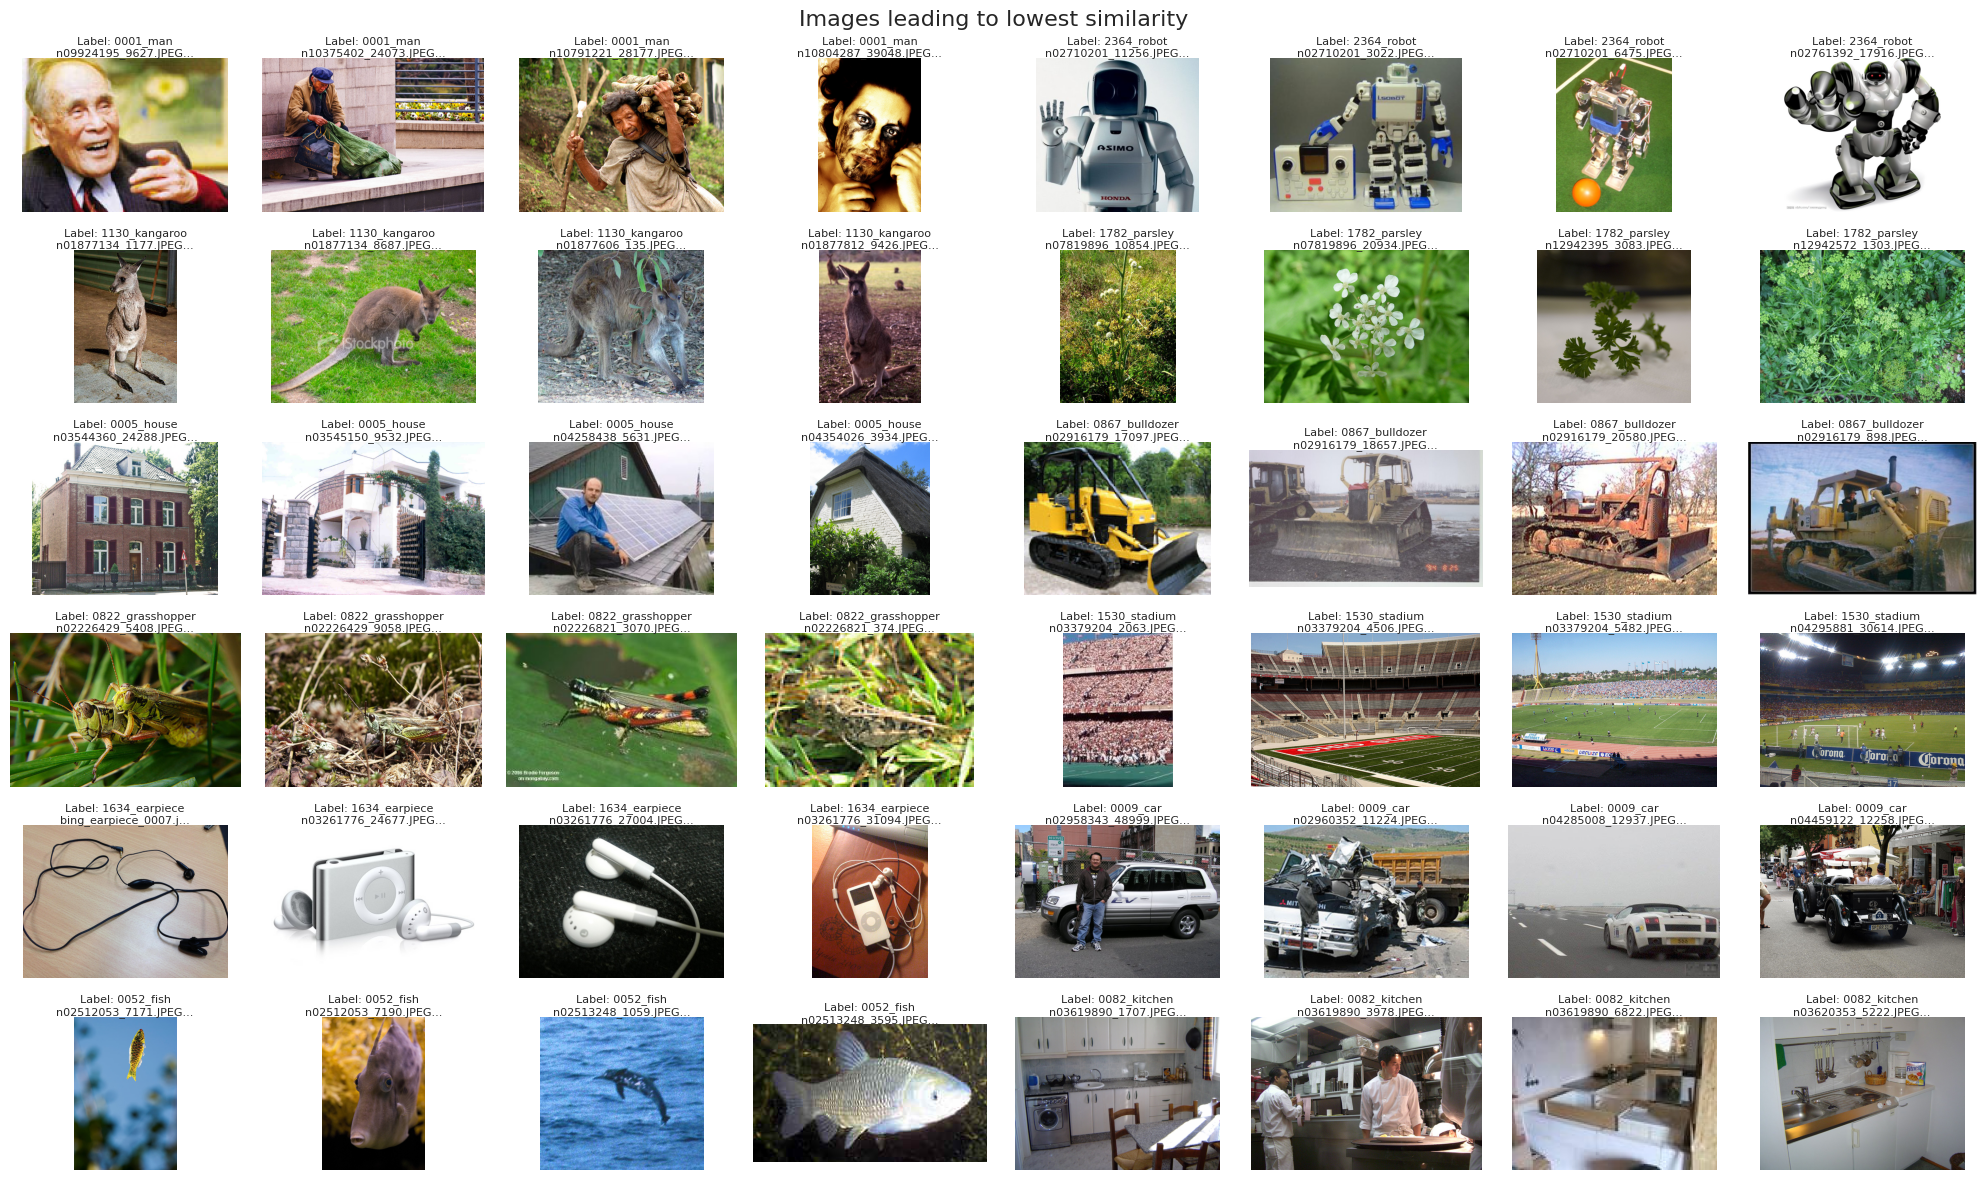

In [41]:
imagelist = [img.replace('/raid/shared/datasets/visoin/', '/home/alban/Documents/') for img in imagelist]
imagespaths = max_rsa.display_low_similarity_images(imagelist, similarity_dict['selected_indices'], n_images=48,
                                                      grid_cols=8, figsize=(20, 12),
                                                      save_path='')

In [13]:
dataset = 'ecoVal'
models  = ['ego', 'saycam']
#models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}
submodels = ['ego', 'saycam']
metric = 'L2squared'
for i, model in enumerate(submodels):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')
    #RDMs[model] = cka.centering(RDMs[model]) # same as centering with matmul

ego
saycam


In [4]:
def sample_rdm_pairs(RDM1, RDM2, n_samples=100000, subset_size=40,
                                    batch_size=10000, seed=None):
    """
    Memory-efficient version that processes in batches and optionally saves to disk.

    Parameters:
    -----------
    batch_size : int
        Number of samples to process at once (default: 1000)
    output_file : str, optional
        If provided, saves results to this file using pickle
    """

    if seed is not None:
        np.random.seed(seed)

    n_images = RDM1.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_sims_samples = []
    all_indices = []
    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size}...")

    for batch_idx in tqdm_notebook(range(n_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        current_batch_size = end_idx - start_idx

        # Allocate batch arrays
        batch_sim = np.zeros((current_batch_size))
        batch_indices = np.zeros((current_batch_size, subset_size), dtype=int)

        for i in range(current_batch_size):
            # Randomly select images
            indices = np.random.choice(n_images, size=subset_size, replace=False)
            indices = np.sort(indices)

            # Extract submatrices
            batch_sim[i] = rsa.Compute_sim_RDMs(RDM1[np.ix_(indices, indices)], RDM2[np.ix_(indices, indices)], center = False, metric = 'pearson' )
            batch_indices[i] = indices

        all_sims_samples.append(batch_sim)
        all_indices.append(batch_indices)

    # Concatenate all batches
    sim_samples = np.concatenate(all_sims_samples, axis=0)
    indices_used = np.concatenate(all_indices, axis=0)


    return sim_samples, indices_used

In [22]:
from itertools import combinations
def find_max_dissimilarity_images(cat_activations, models, categories, nb_per_cat,
                                  images_per_subset=4, dissimilarity_metric = 'L2squared', diff = np.array([0])):
    """
    Find the subset of images per category that maximizes RDM dissimilarity between two models.

    Parameters:
    -----------
    cat_activations : dict
        Dictionary with structure: cat_activations[model][category] = array of activations (n_images, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices
    compute_RDM : function
        Function that takes activations and returns RDM: RDM = compute_RDM(activations)
    images_per_subset : int
        Number of images to select per category (default: 4)
    method : str
        'exhaustive' or 'random' sampling of combinations

    Returns:
    --------
    results : dict
        Dictionary with results for each category:
        {
            category: {
                'best_indices': array of selected image indices,
                'max_dissimilarity': maximum dissimilarity value,
                'model1_rdm': RDM for model1 with selected images,
                'model2_rdm': RDM for model2 with selected images,
                'similarity': similarity between the two RDMs
            }
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    results = {}

    #### First build the RDMs using all images of the chosen categories to get the general stats
    cat_activations_subset1 = cat_activations[models[0]][categories]
    cat_activations_subset2 = cat_activations[models[1]][categories]

    cat_shape = cat_activations_subset1.shape

    RDM1 = rsa.compute_RDMs(cat_activations_subset1.reshape(cat_shape[0]*cat_shape[1], -1), metric = dissimilarity_metric, display = False)
    RDM2 = rsa.compute_RDMs(cat_activations_subset2.reshape(cat_shape[0] * cat_shape[1], -1),
                            metric=dissimilarity_metric, display=False)
    means = {}
    n = len(RDM1)
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDM1[upper_indices])
    means['y'] = np.mean(RDM2[upper_indices])
    means['norm'] = np.std(RDM1[upper_indices]) * np.std(RDM2[upper_indices])
    print(means)
    for c, category in enumerate(tqdm_notebook(categories, desc="Processing categories")):
        print(f"\nProcessing category: {category}")
        # Get activations for both models for this category
        cat_RDM1 = RDM1[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)
        cat_RDM2 = RDM2[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat]  # Shape: (50, 50)

        # Generate combinations of image indices
        all_combinations = list(combinations(range(nb_per_cat), images_per_subset))

        print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

        best_indices = None
        best_model1_rdm = None
        best_model2_rdm = None
        best_similarity = 1

        # Test each combination
        for combination in tqdm_notebook(all_combinations, desc="Testing combinations", leave=False, position=1):
            indices = np.array(combination)
            # Get subset of activations
            rdm1 = cat_RDM1[np.ix_(indices, indices)]  # Shape: (4, 4)
            rdm2 = cat_RDM2[np.ix_(indices, indices)]  # Shape: (4, 4)

            n = len(rdm1)
            upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
            if diff[c] <0:
                similarity = -np.mean(rdm1[upper_indices])/means['x'] + np.mean(rdm2[upper_indices])/means['y'] + 0.5*rsa.Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'pearson_global', means= means)
            else:
                similarity = np.mean(rdm1[upper_indices])/means['x'] - np.mean(rdm2[upper_indices])/means['y'] + 0.5*rsa.Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'pearson_global', means= means)

            # Update best if this is better
            if similarity < best_similarity:
                best_indices = indices
                best_model1_rdm = rdm1
                best_model2_rdm = rdm2
                best_similarity = similarity

        # Store results for this category
        results[category] = {
            'best_indices': best_indices,
            'model1_rdm': best_model1_rdm,
            'model2_rdm': best_model2_rdm,
            'similarity': best_similarity
        }

        print(f"Best indices for {category}: {best_indices}")
        print(f"Similarity: {best_similarity:.4f}")

    return results

In [17]:
imagelist = imagelists['saycam'] # since they are the same, only consider one list
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])
#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per category

compactness, compact_categories = max_rsa.compute_compactness(cat_activations, models, listcat, measure = 'Fisher_discriminant')


ego
saycam


IndexError: index 12 is out of bounds for axis 0 with size 12

12
The 12 categories leading to the max differences between saycam and ego are ['0052_fish' '0157_milk' '0513_acorn' '1297_crown' '0005_house'
 '0784_leek' '0009_car' '0116_flower' '2400_geyser' '0091_bridge'
 '1120_tunnel' '1923_squeegee']
Category numbers are [ 13  55 185 376   1 246   2  36 526  28 332 479]
With differences in compactness of  [-0.87033546 -0.8226196  -0.6882987  -0.6170043  -0.6160693  -0.5441166
  0.5182126  -0.51347107 -0.51221204  0.49745438 -0.48711997 -0.47944856]
{'x': np.float32(1.1459895), 'y': np.float32(1.4862679), 'norm': np.float32(0.016856395)}


Processing categories:   0%|          | 0/12 [00:00<?, ?it/s]


Processing category: 13
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 13: [ 7 13 30 47]
Similarity: -0.4830

Processing category: 55
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 55: [ 5 22 32 35]
Similarity: -0.3343

Processing category: 185
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 185: [ 5 12 24 29]
Similarity: -0.3594

Processing category: 376
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 376: [14 15 17 37]
Similarity: -0.4246

Processing category: 1
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 1: [13 18 35 42]
Similarity: -0.1301

Processing category: 246
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 246: [11 19 32 38]
Similarity: -0.5009

Processing category: 2
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 2: [12 20 41 47]
Similarity: -0.2025

Processing category: 36
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 36: [11 19 33 43]
Similarity: -0.7083

Processing category: 526
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 526: [ 5 12 35 48]
Similarity: -0.1736

Processing category: 28
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 28: [ 1 26 41 46]
Similarity: -0.5324

Processing category: 332
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 332: [ 8 11 22 26]
Similarity: -0.3202

Processing category: 479
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 479: [10 21 31 39]
Similarity: -0.2901
{'x': np.float32(1.1459895), 'y': np.float32(1.4862679), 'norm': np.float32(0.016856395)}

Total selected images: 48
Extracting sub-RDMs...
RDM shapes: (48, 48), (48, 48)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.455209


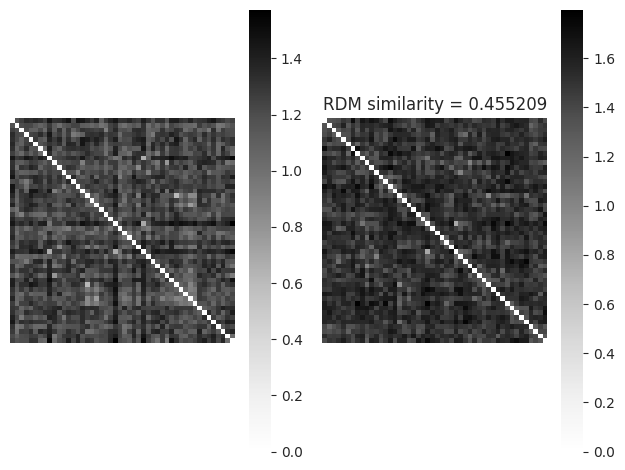

In [23]:
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(
                compact_categories, compactness, 565, listcat, models = ['saycam', 'ego'],
                nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff'
            )
max_dissimilarity_images = find_max_dissimilarity_images(
                cat_activations, ['saycam', 'ego'], labels[:12], 50,
                images_per_subset=4, diff = maxdiffs
            )
similarity_dict = max_rsa.compute_sub_rdm_similarity(
            max_dissimilarity_images, cat_activations, ['saycam', 'ego'], labels[:12],
            savename = '')